# Hough on Triplets

Finding valid triplets using a Hough-Transform approach.

In [30]:
%matplotlib inline

import numpy as np
import pandas as pd
from trackml.dataset import load_event
import seaborn as sns
import matplotlib.pyplot as plt
import random

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [31]:
path2data = '/home/alepfu/Desktop/dataset/train_100_events/'
event_id = 'event000001000'
hits, cells, particles, truth = load_event(path2data + event_id)

data = pd.merge(pd.merge(truth, pd.DataFrame(hits), on = ['hit_id']), pd.DataFrame(particles), on = ['particle_id']).loc[:,['hit_id', 'particle_id', 'x', 'y', 'z','volume_id','layer_id']]
data['r'] = data.apply(lambda h: np.sqrt(h['x']**2 + h['y']**2), axis=1)
data['volume_layer'] = data.apply(lambda h: str(int(h['volume_id'])) + '_' + str(int(h['layer_id'])), axis=1)

N_sample_tracks = 200
data_sample = data.loc[data['particle_id'].isin(random.sample(list(data['particle_id'].unique()), N_sample_tracks))].copy()
data_sample.head(3)

,hit_id,particle_id,x,y,z,volume_id,layer_id,r,volume_layer
1507,159,743099092476887040,-42.819302,-39.234200,-1502.5,7,2,58.075942,7_2
1508,181,743099092476887040,-42.670898,-39.144299,-1498.0,7,2,57.905800,7_2
1509,1630,743099092476887040,-36.925701,-34.332100,-1302.5,7,4,50.420239,7_4


In [32]:
# Get only hits from the centered outer detector strips.
hits_outer = data_sample.loc[data_sample['volume_layer'].isin(['17_4','17_2','13_8'])]

# Merge hits from overlapping detector panels
hits_outer = hits_outer.groupby(['particle_id','volume_layer']).agg({'hit_id':'first', 'x':'mean', 'y':'mean', 'z':'mean', 'r':'mean'}).reset_index()
hits_outer.head(3)

,particle_id,volume_layer,hit_id,x,y,z,r
0,22529405569990656,13_8,91750,468.059998,464.967010,-901.599976,659.753349
1,27024002996256770,13_8,94687,417.369995,508.084015,130.000000,657.531048
2,27024002996256770,17_2,110915,526.585999,632.679016,179.000000,823.149775


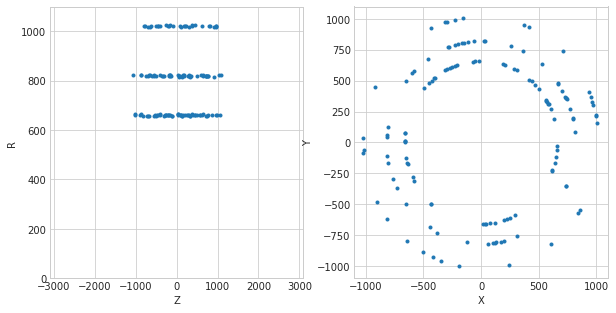

In [33]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(hits_outer['z'], hits_outer['r'],".")
plt.xlabel("Z")
plt.ylabel("R")
plt.xlim((-3100,3100))
plt.ylim((0,1100))
plt.subplot(1,2,2)
plt.plot(hits_outer['x'], hits_outer['y'],".")
plt.xlim((-1100,1100))
plt.ylim((-1100,1100))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [34]:
from hough_trans import Clusterer


model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=3) # since we want to form triplets

hits_outer = hits_outer.loc[:,['hit_id','x','y', 'z']]
labels = model.predict(hits_outer)

hits_outer['label'] = labels

hits_outer.head(3)

,hit_id,x,y,z,label
0,91750,468.059998,464.967010,-901.599976,0.0
1,94687,417.369995,508.084015,130.000000,24.0
2,110915,526.585999,632.679016,179.000000,0.0


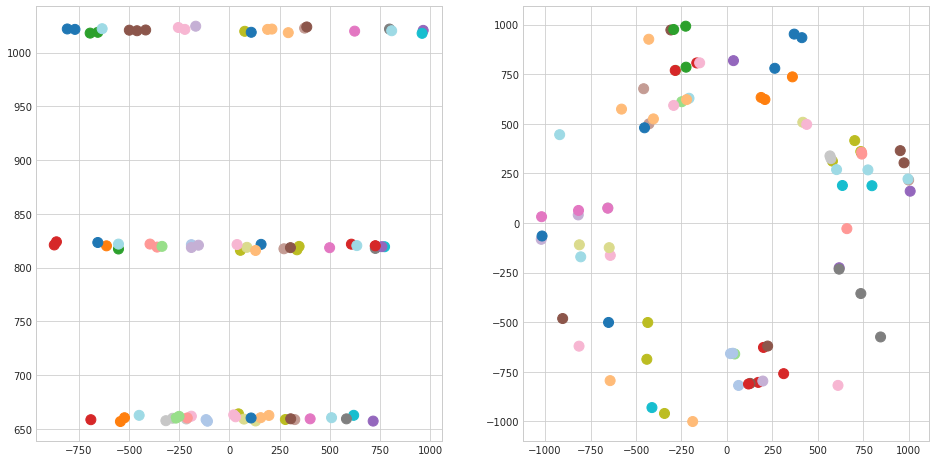

In [35]:
hits_outer['r'] = hits_outer.apply(lambda h: np.sqrt(h['x']**2 + h['y']**2), axis=1)

hits_outer_found = hits_outer[hits_outer['label']!=0].copy()

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(hits_outer_found['z'], hits_outer_found['r'], c=hits_outer_found['label'], label=hits_outer_found['label'], s=100, cmap='tab20');
plt.subplot(1,2,2)
plt.scatter(hits_outer_found['x'], hits_outer_found['y'], c=hits_outer_found['label'], label=hits_outer_found['label'], s=100, cmap='tab20');
plt.show()

In [36]:
found_triplets = pd.DataFrame(hits_outer[hits_outer['label']!=0].sort_values('label'))
check = pd.merge(found_triplets, truth, on=['hit_id'])
check = check[['hit_id','particle_id','label']]
group = check.groupby('label').agg({'particle_id':pd.Series.nunique})

print('Accurate found triplets:', len(group[group['particle_id']==1.0])/len(group))

Accurate found triplets: 0.1111111111111111


### Triplet finding on the whole dataset

In [37]:
%%time

from hough_trans import Clusterer

hits_all = data.copy()

# Merge hits from overlapping detector panels
hits_all = hits_all.groupby(['particle_id','volume_layer']).agg({'hit_id':'first', 'x':'mean', 
                                                                 'y':'mean', 'z':'mean', 'r':'mean'}).reset_index()

model_all = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=3) # since we want to form triplets
hits_all= hits_all.loc[:,['hit_id','x','y', 'z']]
labels_all = model_all.predict(hits_all)
hits_all['label'] = labels_all

found_triplets_all = pd.DataFrame(hits_all[hits_all['label']!=0].sort_values('label'))
check_all = pd.merge(found_triplets_all, truth, on=['hit_id'])
check_all = check_all[['hit_id','particle_id','label']]
group_all = check_all.groupby('label').agg({'particle_id':pd.Series.nunique})

print('Accurate found triplets:', len(group_all[group_all['particle_id']==1.0])/len(group_all))

Accurate found triplets: 0.06798328902392708
CPU times: user 1min 14s, sys: 769 ms, total: 1min 15s
Wall time: 1min 16s


# TODO: proceed here with Hough-space viz

## TODO: Look how min_hits constraint is set in hough_trans.py